In [1]:
using Pkg
Pkg.activate(joinpath(Pkg.devdir(),"TaskGraphs"));

In [2]:
using TaskGraphs

┌ Info: Recompiling stale cache file /home/kylebrown/.julia/compiled/v1.0/TaskGraphs/apcwx.ji for TaskGraphs [6635cb54-791c-11e9-2805-8512ad3937f9]
└ @ Base loading.jl:1190


In [3]:
using CRCBS
using LightGraphs, MetaGraphs
using LinearAlgebra
using DataStructures
# using JuMP, MathOptInterface
# using Gurobi
using TOML
using Random

using GraphUtils

In [439]:
include(joinpath(dirname(pathof(TaskGraphs)),"..","test","notebooks","render_tools.jl"));

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


# Experiments:

Generate 4 environments for all experiments

In [ ]:
# env_graphs = []
# envs = []
# num_obstacle_cells = 64
# for (i,n) in enumerate([2,4,8])
#     obs_w = Int(sqrt(num_obstacle_cells)/n)
#     env = construct_regular_factory_world(;
#         n_obstacles_x=n,
#         n_obstacles_y=n,
#         obs_width = [obs_w;obs_w],
#         obs_offset = [obs_w;obs_w],
#         env_pad = [1;1],
#         env_offset = [1,1],
#         env_scale = 1 # this is essentially the robot diameter
#     )
#     filename = string(TaskGraphs.ENVIRONMENT_DIR,"/env_",i,".toml")
#     open(filename,"w") do io
#         TOML.print(io,env)
#     end
#     # graphics_filename = string(TaskGraphs.ENVIRONMENT_DIR,"/env_",i,".svg")
#     # visualize_env(env) |> SVG(graphics_filename)
#     push!(envs, env)
# end

In [ ]:
i = 2;
set_default_plot_size(10cm,10cm);
filename = string(TaskGraphs.ENVIRONMENT_DIR,"/env_",i,".toml");
factory_env = read_env(filename);
env_graph = factory_env;
dist_matrix = get_dist_matrix(env_graph);
p = visualize_env(factory_env)
# p |> PDF(joinpath("/home/kylebrown/Repositories/task_graphs_icra_paper/graphics","env_graph.pdf"))

# Record Video

In [ ]:
problem_id = 3
results_filename = joinpath(Pkg.devdir(),"TaskGraphs","dummy_results_dir","SparseAdjacencyMILP",string(:full_solver),string("results",problem_id,".toml"))
toml_dict = TOML.parsefile(results_filename);
robot_paths = Vector{Vector{Int}}(toml_dict["robot_paths"]);
object_paths = Vector{Vector{Int}}(toml_dict["object_paths"]);
object_intervals = Vector{Vector{Int}}(toml_dict["object_intervals"]);
tf = maximum(map(p->length(p),robot_paths))
set_default_plot_size(18cm,18cm)
record_video(joinpath(VIDEO_DIR,string("problem",problem_id,".webm")),
    t->render_paths(t,robot_paths,object_paths;object_intervals=object_intervals);tf=tf)

# Load results into dataframes

In [ ]:
# N_problems = 384
# problem_dir = PROBLEM_DIR
# results_dir = RESULTS_DIR
# # results_dir = joinpath(EXPERIMENT_DIR,"adjacency_solver/results")
# config_df = construct_config_dataframe(problem_dir,N_problems);

In [ ]:
# df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems)

# Display experimental results

In [5]:
set_default_plot_size(28cm,12cm)

In [ ]:
# p1 = robots_vs_task_vs_time_box_plot(df_dict[:full_solver]; 
#     title="Full Algorithm")
# # p1 |> PDF("FullAlgorithm.pdf", 20cm, 12cm)
# # p1

In [407]:
N_problems = 192
# problem_dir = joinpath(PROBLEM_DIR,"collaborative_transport")
problem_dir = joinpath(PROBLEM_DIR,"collaborative_transport/final")
# results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/collaborative_transport_dist_maps/results")
results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/final/results")
# results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/collaborative_transport/results")
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems);
preprocess_collab_results!(df_dict);

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


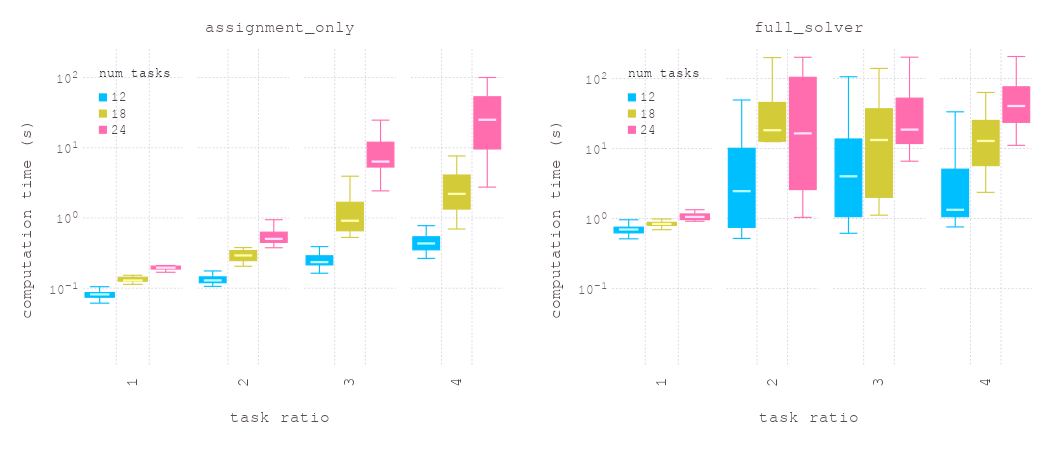

In [415]:
p1 = hstack(
    plot_collab_runtimes(
            df_dict[:assignment_only]; 
            title="assignment_only",big_font=12pt,small_font=10pt,
#             suppress_outliers=false
        ),
#     plot_collab_runtimes(
#             df_dict[:low_level_search_without_repair]; 
#             title="low_level_search_without_repair",big_font=12pt,small_font=10pt,
#             suppress_outliers=false
#         ),
    plot_collab_runtimes(
            df_dict[:full_solver][df_dict[:full_solver].feasible,:]; 
            title="full_solver",big_font=12pt,small_font=10pt,
#             suppress_outliers=false
        ),
    
    )

In [400]:
# df = df_dict[:low_level_search_without_repair]
# plot(
#     layer(df_dict[:assignment_only][df.cost .< 1000,:], x=:problem_id, y=:cost,  Theme(default_color="red")),
#     layer(df_dict[:low_level_search_without_repair][df.cost .< 1000,:], x=:problem_id, y=:cost, size=[5pt], Geom.point),
# )

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


In [ ]:
p1 |> SVG("CollabResults.svg", 28cm, 12cm)

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


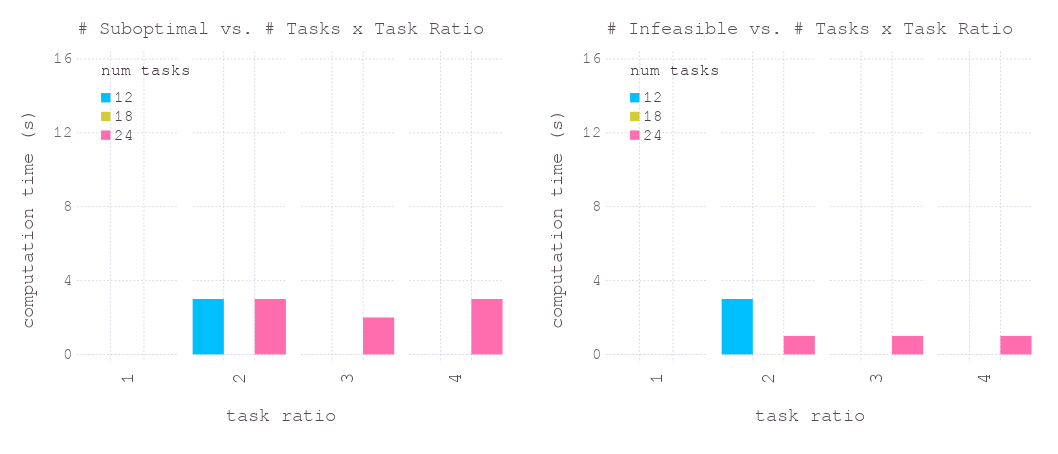

In [416]:
hstack(
    plot_collab_counts(df_dict[:full_solver];key=df_dict[:full_solver].optimal,
        title="# Suboptimal vs. # Tasks x Task Ratio"),
    plot_collab_counts(df_dict[:full_solver];key=df_dict[:full_solver].feasible,
        title="# Infeasible vs. # Tasks x Task Ratio")
)

In [413]:
@show sum(df_dict[:full_solver].feasible .== false)
@show sum(df_dict[:full_solver].optimal .== false)

sum((df_dict[:full_solver]).feasible .== false) = 6
sum((df_dict[:full_solver]).optimal .== false) = 11


┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


11

In [396]:
# N_problems = 384
# problem_dir = PROBLEM_DIR
# # results_dir = RESULTS_DIR
# results_dir = joinpath(EXPERIMENT_DIR,"assignment_solver/results")
# df_dict1 = construct_result_dataframes(problem_dir,results_dir,N_problems)
# preprocess_results!(df_dict1)
# p1 = hstack(
#     robots_vs_task_vs_time_box_plot(
#         df_dict1[:assignment_only]; 
#         title="Assignment Only (with Assignment MILP)",big_font=12pt,small_font=10pt),
#     robots_vs_task_vs_time_box_plot(
#         df_dict1[:low_level_search_without_repair]; 
#         title="low Level Search (with Assignment MILP)",big_font=12pt,small_font=10pt)
#     )

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


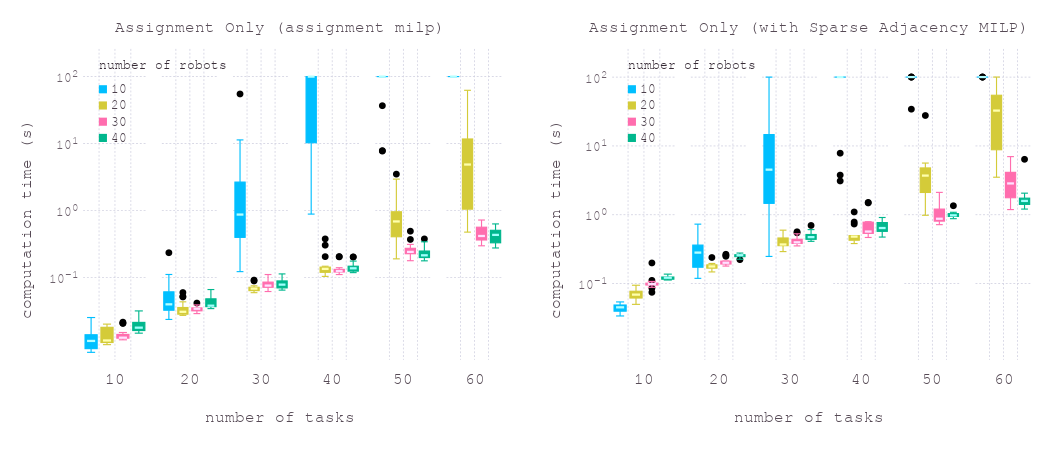

In [444]:
N_problems = 384
problem_dir = PROBLEM_DIR
results_dir = joinpath(EXPERIMENT_DIR,"assignment_solver/results")
# results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/results")
df_dict1 = construct_result_dataframes(problem_dir,results_dir,N_problems)
preprocess_results!(df_dict1)
results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/results")
df_dict2 = construct_result_dataframes(problem_dir,results_dir,N_problems)
preprocess_results!(df_dict2)
p1 = hstack(
    robots_vs_task_vs_time_box_plot(
        df_dict1[:assignment_only]; 
#         title="Assignment Only (with Assignment MILP)",big_font=12pt,small_font=10pt),
        title="Assignment Only (assignment milp)",big_font=12pt,small_font=10pt),
    robots_vs_task_vs_time_box_plot(
        df_dict2[:assignment_only]; 
        title="Assignment Only (with Sparse Adjacency MILP)",big_font=12pt,small_font=10pt)
    )

In [492]:
df = DataFrame(
    problem_id = df_dict1[:assignment_only].problem_id,
    time_assignment = df_dict1[:assignment_only].time, # optimal cost
    M = df_dict1[:assignment_only].M,
    N = df_dict1[:assignment_only].N,
)
df = join(df[df.time_assignment .< 90.0,:],
    df_dict2[:assignment_only][df_dict2[:assignment_only].time .< 90.0,[:problem_id, :time]],
    on = :problem_id,kind = :inner, makeunique=true);
begin df[!,:time_gap] = df.time .- df.time_assignment
    df
end
begin df[!,:relative_time_gap] = df.time_gap ./ df.time_assignment
    df
end
preprocess_results!(df)
maximum(df.time_gap)

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


79.532226702

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


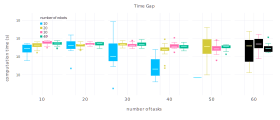

In [487]:
robots_vs_task_vs_time_box_plot(
        df; 
        title="Time Gap",big_font=12pt,small_font=10pt,
        y=:relative_time_gap,
    )

In [489]:
sum(df.relative_time_gap) / nrow(df)

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


4.989477674342994

In [495]:
sort(df.relative_time_gap)[167]

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


4.09467690870355

In [ ]:
p1 |> SVG("AssignmentHeadToHead.svg", 28cm, 12cm)

In [ ]:
# set_default_plot_size(20cm,9cm)
# p3 = robots_vs_task_vs_time_box_plot(
#     df_dict[:low_level_search_with_repair];title=nothing,yticks=[-1,0,1],ymin=-1.5,ymax=0.2)

In [14]:
using PGFPlotsX
latexengine!(PGFPlotsX.PDFLATEX)
using Printf

In [289]:
function get_box_plot_group_plot(df;
        obj=:time,
        outer_key=:M,
        inner_key=:N,
        outer_range=10:10:60,
        inner_range=10:10:40,
        xmin=0, 
        xmax=length(inner_range)+1,
        ymin=0.007,
        ymax=120,
        xtick=[10,20,30,40],
        xticklabels=[10,20,30,40],
        tickpos="left",
        ytick=[0.1,1,10,100],
        ylabel_shift="0pt",
        title="",
        title_shift=[3.3,2.55],
        inner_sym="n",
        outer_sym="m",
        xlabels=map(m->string(outer_sym," = ",m), outer_range),
        ylabels=map(n->string(inner_sym," = ",n), inner_range),
        ylabel="time (s)",
        draw_labels=true,
        ymode="log",
        width="3.25cm",
        height="6cm",
        legend_draw="none",
        legend_fill="none",
        legend_x_shift="2pt"
    )
    @pgf gp = GroupPlot({group_style = { 
                "group name"="myPlots",
                "group size"=string(length(outer_range)," by 1"),
                "xlabels at"="edge bottom",
                "xticklabels at"="edge bottom",
                "vertical sep"="0pt",
                "horizontal sep"="2pt"
            },
            boxplot,
            "boxplot/draw direction"="y",
            ymode=ymode,
            footnotesize,
            width=width,
            height=height,
            xmin=xmin, 
            xmax=xmax,
            ymin=ymin,
            ymax=ymax,
            xtick=xtick,
            xticklabels=xtick,
            tickpos=tickpos,
            ytick=ytick,
            yticklabels=[],
#             "set layers"="standard",
            "ylabel shift"=ylabel_shift,
            "ytick align"="outside",
            "xtick align"="outside",
            "legend entries"={map(j->@sprintf("\$%s\$",ylabels[j]),1:length(inner_range))...},
            "legend cell align"="left",
            "legend to name"="grouplegend",
            "legend style"={
                draw=legend_draw,
                fill=legend_fill,
                xshift=legend_x_shift,
                yshift="0pt",
                font="\\scriptsize"
            },
            "legend pos"="north west"}
        
        );

    @pgf for (i,m) in enumerate(outer_range)
        if i == 1 && draw_labels
            push!(gp, 
                """
                \\coordinate (leg) at (rel axis cs:0,1);
                """
            )
            push!(gp, 
                {xlabel=@sprintf("\$%s\$",xlabels[i]),
                ylabel=ylabel,
                yticklabels=ytick,
#                 "legend style"={
#                     draw=legend_draw,
#                     fill=legend_fill,
#                     xshift=legend_x_shift,
#                     yshift="0pt"},
#                 "legend pos"="north west"
                },
#                 map(j->LegendEntry({},@sprintf("\$%s\$",ylabels[j]),false),1:length(inner_range))...,
                """
                \\addlegendimage{no markers,blue}
                \\addlegendimage{no markers,red}
                \\addlegendimage{no markers,brown}
                \\addlegendimage{no markers,black}
                """,
                map(n->PGFPlotsX.PlotInc({boxplot},Table(
                            {"y index"=0},
                            [:data=>df[(df[:,outer_key] .== m) .& (df[:,inner_key] .== n),obj]])),inner_range)...)
        else
            push!(gp, {
                    xlabel=@sprintf("\$%s\$",xlabels[i]),
                    ymajorticks="false",
                    yminorticks="false"
                },
                map(n->PGFPlotsX.PlotInc({boxplot},Table(
                            {"y index"=0},
                            [:data=>df[(df[:,outer_key] .== m) .& (df[:,inner_key] .== n),obj]])),inner_range)...)
        end
    end;
    gp
end
function get_runtime_box_plot(df;
        title="",
        title_shift=[3.3,2.55],
        scale=0.7,
        kwargs...)
    gp = get_box_plot_group_plot(df;kwargs...)
    if title != ""
        tikzpic = @pgf TikzPicture({scale=scale},
            """
            \\centering
            \\pgfplotsset{set layers=standard,cell picture=true}
            """,
            gp,
            @sprintf("""
            \\node (title) at (\$(myPlots c1r1.center)!0.5!(myPlots c2r1.center)+(%2.2fcm,%2.2fcm)\$) {\\textbf{%s}};
            """,title_shift...,title,
            """
            \\node[anchor= north west] (leg) at (myPlots c1r1.north west){\\pgfplotslegendfromname{grouplegend}};
            """)
        )
    else
        tikzpic = @pgf TikzPicture({scale=scale},
            """
            \\centering
            \\pgfplotsset{set layers=standard,cell picture=true}
            """,
            gp,
            """
            \\node[anchor= north west] (leg) at (myPlots c1r1.north west){\\pgfplotslegendfromname{grouplegend}};
            """
        )
    end
    return tikzpic
end

# print_tex(gp)

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/task_graphs_core.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/task_graphs_core.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


get_runtime_box_plot (generic function with 1 method)

# Plot runtime results in box plots across collaborative tasks

In [402]:
N_problems = 192
problem_dir = joinpath(PROBLEM_DIR,"collaborative_transport/final")
# results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/collaborative_transport_dist_maps/results")
results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/final/results")
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems);
preprocess_collab_results!(df_dict);

mode_list = [:full_solver,:assignment_only,:low_level_search_without_repair,:low_level_search_with_repair]
tmin = minimum(map(MODE->minimum(df_dict1[MODE].time),mode_list))
base_dir = joinpath("/home/kylebrown/Repositories/task_graphs_icra_paper/results")
for (filename, title, draw_labels,t_lo) in [
        (:assignment_only,"",true,tmin),
        (:low_level_search_without_repair,"",false,tmin),
        (:full_solver,"",true,0.5)
        ]

    open(joinpath(base_dir,string(filename,".tex")),"w") do io
        gp = get_runtime_box_plot(
            df_dict[filename];
            ymin=t_lo,
            title=title,
            obj=:time,
            outer_key=:TaskRatio,
            inner_key=:M,
            outer_range=1:1:4,
            inner_range=12:6:24,
            inner_sym="m",
            outer_sym="ratio",
            xtick=[12,18,24],
            title_shift=[1.8,2.55],
            draw_labels=draw_labels
        )
        print_tex(io, gp)
    end
end

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


# Plot Relative Optimality gap between optimal solver and greedy algorithm

In [403]:
N_problems = 192
# problem_dir = joinpath(PROBLEM_DIR,"collaborative_transport")
# results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/non_zero_collect_time/results")
problem_dir = joinpath(PROBLEM_DIR,"collaborative_transport/final")
results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/final/results")
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems);
preprocess_collab_results!(df_dict);
df1 = df_dict[:assignment_only]
# results_dir = joinpath(EXPERIMENT_DIR,"greedy_assignment/non_zero_collect_time/results")
results_dir = joinpath(EXPERIMENT_DIR,"greedy_assignment/final/results")
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems);
preprocess_collab_results!(df_dict);
df2 = df_dict[:assignment_only];

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


In [404]:
# df = join(df1,df2,on = :problem_id,kind = :inner, makeunique=true);
df = DataFrame(
    problem_id = df1.problem_id,
    cost1 = df1.cost, # optimal cost
    M = df1.M,
    TaskRatio = df1.TaskRatio
)
df = join(df,df2,on = :problem_id,kind = :inner, makeunique=true);
begin df[!,:optimality_gap] = df.cost .- df.cost1
    df
end
begin df[!,:relative_gap] = df.optimality_gap ./ df.cost1
    df
end

base_dir = joinpath("/home/kylebrown/Repositories/task_graphs_icra_paper/results")
open(joinpath(base_dir,"baseline_cost_comparison.tex"),"w") do io
    gp = get_runtime_box_plot(
        df;
        ymin=-0.1,
        ymax=2.0,
        ymode="normal",
        ylabel="relative optimality gap",
        title="",
        obj=:relative_gap,
        outer_key=:TaskRatio,
        inner_key=:M,
        outer_range=1:1:4,
        inner_range=12:6:24,
        inner_sym="m",
        outer_sym="ratio",
        xtick=[12,18,24],
        ytick=[0.0,0.5,1.0,1.5,2.0],
        title_shift=[1.8,2.55],
#         draw_labels=draw_labels
    )
    print_tex(io, gp)
end

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


# Compare assignment milp to sparse adjacency milp

In [405]:
N_problems = 384
problem_dir = PROBLEM_DIR
results_dir = joinpath(EXPERIMENT_DIR,"assignment_solver","results")
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems);
preprocess_results!(df_dict);
df1 = df_dict[:assignment_only]
results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/results")
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems);
preprocess_results!(df_dict);
df2 = df_dict[:assignment_only];

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


In [406]:
tmin = min(minimum(df1.time),minimum(df2.time))
base_dir = joinpath("/home/kylebrown/Repositories/task_graphs_icra_paper/results")
for (df, filename, title,draw_labels) in [
        (df1,"assignment_milp_runtime","",true),
        (df2,"sparse_adjacency_milp_single_tasks_runtime","",false),
        ]

    open(joinpath(base_dir,string(filename,".tex")),"w") do io
        gp = get_runtime_box_plot(
            df;
            ymin=tmin,
            title=title,
            obj=:time,
            outer_key=:M,
            inner_key=:N,
            outer_range=10:10:60,
            inner_range=10:10:30,
            inner_sym="n",
            outer_sym="m",
            xtick=[10,20,30],
            draw_labels=draw_labels,
            width="2.75cm",
            legend_draw="black",
            legend_fill="white"
        )
        print_tex(io, gp)
    end
end

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/CRCBS/src/low_level_search/heuristics.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


In [ ]:
# titles = Dict(
#     :full_solver => "Runtime of Full \\PCTAPF{} Solver",
#     :assignment_only => "Runtime of Task Assignment MILP Solver",
#     :low_level_search_with_repair => "Runtime of \\LevelThreeLong{}",
#     :low_level_search_without_repair => "Runtime of \\LevelThreeLong{}",
# )
titles = Dict(
    :full_solver => "Experimental Results (Runtime)",
    :assignment_only => "",
    :low_level_search_with_repair => "",
    :low_level_search_without_repair => "",
)
for MODE in [:full_solver,:assignment_only,:low_level_search_without_repair,:low_level_search_with_repair]
    gp = get_runtime_box_plot(df_dict[MODE];ymin=tmin,title=titles[MODE])
#     open(joinpath("/home/kylebrown/Repositories/task_graphs_icra_paper/graphics",string(MODE,".tex")),"w") do io
    open(string(MODE,".tex"),"w") do io
        print_tex(io, gp)
    end
end